# Lab3

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
!git clone https://github.com/csaw-hackml/CSAW-HackML-2020.git

Cloning into 'CSAW-HackML-2020'...
remote: Enumerating objects: 220, done.
remote: Counting objects: 100% (56/56), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 220 (delta 27), reused 0 (delta 0), pack-reused 164
Receiving objects: 100% (220/220), 85.94 MiB | 23.86 MiB/s, done.
Resolving deltas: 100% (82/82), done.


Copy data to '/content/CSAW-HackML-2020/lab3/data/' from my google drive, you can also upload the data manually

In [ ]:
!cp -r /gdrive/MyDrive/ML_Cyber/bd /content/CSAW-HackML-2020/lab3/data/bd
!cp -r /gdrive/MyDrive/ML_Cyber/cl /content/CSAW-HackML-2020/lab3/data/cl

In [ ]:
import tensorflow as tf
import h5py
import numpy as np
import matplotlib.pyplot as plt
import keras
import keras.backend as K
from keras import models
from keras.models import Model
from keras import initializers

import sys
sys.path.append('/content/CSAW-HackML-2020')
import architecture
from architecture import Net
from eval import data_loader
from eval import data_preprocess

import warnings
warnings.filterwarnings('ignore')

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2" #remove the warning of the tensorflow

# 1.Load and preprocess data

In [ ]:
x_val_cl, y_val_cl = data_loader('/content/CSAW-HackML-2020/lab3/data/cl/valid.h5')
x_test_cl, y_test_cl = data_loader('/content/CSAW-HackML-2020/lab3/data/cl/test.h5')
x_val_bd, y_val_bd = data_loader('/content/CSAW-HackML-2020/lab3/data/bd/bd_valid.h5')
x_test_bd, y_test_bd = data_loader('/content/CSAW-HackML-2020/lab3/data/bd/bd_test.h5')

In [ ]:
# count how many classes
num_class_val = len(np.unique(y_val_cl))
num_class_test = len(np.unique(x_test_cl))
print('classes in val:', num_class_val)
print('classes in test:', num_class_test)

classes in val: 1283
classes in test: 256


# 2.Load model

In [ ]:
#import model
bd_model = keras.models.load_model('/content/CSAW-HackML-2020/lab3/models/bd_net.h5')

In [ ]:
K.clear_session()
bd_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 55, 47, 3)]  0           []                               
                                                                                                  
 conv_1 (Conv2D)                (None, 52, 44, 20)   980         ['input[0][0]']                  
                                                                                                  
 pool_1 (MaxPooling2D)          (None, 26, 22, 20)   0           ['conv_1[0][0]']                 
                                                                                                  
 conv_2 (Conv2D)                (None, 24, 20, 40)   7240        ['pool_1[0][0]']                 
                                                                                            

In [ ]:
# compute metrics on valid data before pruning
!python /content/CSAW-HackML-2020/lab3/eval.py /content/CSAW-HackML-2020/lab3/data/cl/valid.h5 /content/CSAW-HackML-2020/lab3/data/bd/bd_valid.h5 /content/CSAW-HackML-2020/lab3/models/bd_net.h5

Clean Classification accuracy: 98.64899974019225
Attack Success Rate: 100.0


# 3.Prune the model

### GoodNet class

In [ ]:
#goodnet
class GoodNet(Model):
  def __init__(self, bd_model, bd_model_pruned):
    super(GoodNet, self).__init__()
    self.bd_model = bd_model
    self.bd_model_pruned = bd_model_pruned

  def predict(self, x):
    bd_model_pred = np.argmax(self.bd_model.predict(x), axis=1)
    bd_model_pruned_pred = np.argmax(self.bd_model_pruned.predict(x), axis=1)
    pred = np.zeros(len(bd_model_pred))
    pred[np.where(bd_model_pred==bd_model_pruned_pred)]=bd_model_pred[np.where(bd_model_pred==bd_model_pruned_pred)]
    pred[np.where(bd_model_pred!=bd_model_pruned_pred)]=int(1283+1)
    return pred

### Prune model

In [ ]:
#get the last pooling layer
pool_3 = Model(inputs=bd_model.input, outputs=bd_model.get_layer('pool_3').output)

In [ ]:
#get average activation values for pooling layer 3 over the entire validation set 
pool_3_output = np.mean(pool_3.predict(x_val_cl), axis=0)
idx_order = np.argsort(np.sum(pool_3_output, axis=(0, 1))) #sort in increasing order and return index
print(idx_order)

[ 0 26 27 30 31 33 34 36 37 38 25 39 41 44 45 47 48 49 50 53 55 40 24 59
  9  2 12 13 17 14 15 23  6 51 32 22 21 20 19 43 58  3 42  1 29 16 56 46
  5  8 11 54 10 28 35 18  4  7 52 57]


In [ ]:
# copied from eval.py, using to evaluate model on test set
def compute_acc(y, y_pred):
  clean_accuracy = np.mean(np.equal(y_pred, y))*100
  return clean_accuracy

'''
#eval badnet
def evaluate_bd(bd_model, cl_x_test, cl_y_test, bd_x_test, bd_y_test):
  cl_label_p = np.argmax(bd_model.predict(cl_x_test), axis=1)
  clean_accuracy = np.mean(np.equal(cl_label_p, cl_y_test))*100

  bd_label_p = np.argmax(bd_model.predict(bd_x_test), axis=1)
  asr = np.mean(np.equal(bd_label_p, bd_y_test))*100
  return clean_accuracy, asr
'''

#eval goodnet
def evaluate_gd(gd_model, cl_x_test, cl_y_test, bd_x_test, bd_y_test):
  cl_label_p = gd_model.predict(cl_x_test)
  clean_accuracy = np.mean(np.equal(cl_label_p, cl_y_test))*100

  bd_label_p = gd_model.predict(bd_x_test)
  asr = np.mean(np.equal(bd_label_p, bd_y_test))*100
  return clean_accuracy, asr

In [ ]:
bd_model = keras.models.load_model('/content/CSAW-HackML-2020/lab3/models/bd_net.h5')
bd_model_pruned = keras.models.load_model('/content/CSAW-HackML-2020/lab3/models/bd_net.h5')
# prune: we need to prune conv3 layer to reduce the pool_3 layer channel
conv_3_layer = bd_model_pruned.get_layer('conv_3')
weight, bias = conv_3_layer.get_weights()
prune_time = 0
clean_accuracy_list = []
attack_success_rate_list = []

# store initial metrics
goodnet = GoodNet(bd_model, bd_model_pruned)
clean_accuracy_list.append(evaluate_gd(goodnet, x_test_cl, y_test_cl, x_test_bd, y_test_bd)[0])
attack_success_rate_list.append(evaluate_gd(goodnet, x_test_cl, y_test_cl, x_test_bd, y_test_bd)[1])
for idx in idx_order:
  #prune
  prune_time+=1
  weight[:, :, :, idx] = 0
  bias[idx] = 0
  conv_3_layer.set_weights([weight, bias])

  #compute metrics on val data and store model
  y_val_cl_pred = np.argmax(bd_model_pruned.predict(x_val_cl), axis=1)
  val_cl_acc = compute_acc(y_val_cl, y_val_cl_pred)
  acc_diff = np.round(98.64899974019225 - val_cl_acc, 1)
  if acc_diff>=2:
    bd_model_pruned.save('/content/CSAW-HackML-2020/lab3/models/bd_net_prune_'+'acc'+str(acc_diff)+'.h5')
  print(prune_time, 'val_cl_acc:', val_cl_acc, 'acc_drop:', acc_diff)

  #compute metrics on test data
  goodnet = GoodNet(bd_model, bd_model_pruned)
  clean_accuracy, attack_success_rate = evaluate_gd(goodnet, x_test_cl, y_test_cl, x_test_bd, y_test_bd)
  clean_accuracy_list.append(clean_accuracy)
  attack_success_rate_list.append(attack_success_rate)
  print('clean_accuracy:', clean_accuracy, 'attack_success_rate:', attack_success_rate)

1 val_cl_acc: 98.64899974019225 acc_drop: 0.0
clean_accuracy: 98.62042088854248 attack_success_rate: 100.0
2 val_cl_acc: 98.64899974019225 acc_drop: 0.0
clean_accuracy: 98.62042088854248 attack_success_rate: 100.0
3 val_cl_acc: 98.64899974019225 acc_drop: 0.0
clean_accuracy: 98.62042088854248 attack_success_rate: 100.0
4 val_cl_acc: 98.64899974019225 acc_drop: 0.0
clean_accuracy: 98.62042088854248 attack_success_rate: 100.0
5 val_cl_acc: 98.64899974019225 acc_drop: 0.0
clean_accuracy: 98.62042088854248 attack_success_rate: 100.0
6 val_cl_acc: 98.64899974019225 acc_drop: 0.0
clean_accuracy: 98.62042088854248 attack_success_rate: 100.0
7 val_cl_acc: 98.64899974019225 acc_drop: 0.0
clean_accuracy: 98.62042088854248 attack_success_rate: 100.0
8 val_cl_acc: 98.64899974019225 acc_drop: 0.0
clean_accuracy: 98.62042088854248 attack_success_rate: 100.0
9 val_cl_acc: 98.64899974019225 acc_drop: 0.0
clean_accuracy: 98.62042088854248 attack_success_rate: 100.0
10 val_cl_acc: 98.64899974019225 acc_

# 4.Results

## Plot the accuracy on clean test data and the attack success rate (on backdoored test data) as a function of the fraction of channels pruned.

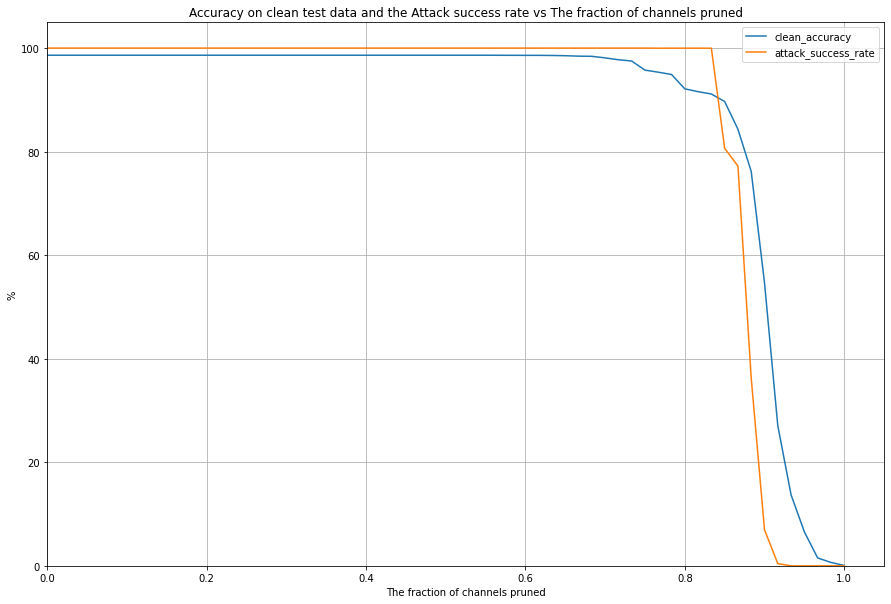

In [ ]:
plt.figure(figsize=(15,10))
plt.plot(np.arange(0,61)/60, clean_accuracy_list, label='clean_accuracy')
plt.plot(np.arange(0,61)/60, attack_success_rate_list, label='attack_success_rate')
plt.title('Accuracy on clean test data and the Attack success rate vs The fraction of channels pruned')
plt.legend()
plt.xlabel('The fraction of channels pruned')
plt.ylabel('%')
plt.xlim(0,)
plt.ylim(0,)
plt.grid('on')

In [ ]:
# transfer model to google drive
#!cp -r /content/CSAW-HackML-2020/lab3/models /gdrive/MyDrive/ML_Cyber/lab3_prune_model/
# transfer model from google drive
#!cp -r /gdrive/MyDrive/ML_Cyber/lab3_prune_model/ /content/CSAW-HackML-2020/lab3/models

## Repaired networks for X={2%,4%,10%,30%}.

Based on the accuracy drop value, we choose model:
- X=2%, /content/CSAW-HackML-2020/lab3/models/bd_net_prune_acc2.9.h5
- X=4%, /content/CSAW-HackML-2020/lab3/models/bd_net_prune_acc6.6.h5
- X=10%, /content/CSAW-HackML-2020/lab3/models/bd_net_prune_acc14.2.h5
- X=30%, /content/CSAW-HackML-2020/lab3/models/bd_net_prune_acc43.8.h5

In [ ]:
!git clone https://github.com/HaoyangPei/ML_cyber_lab3.git

Cloning into 'ML_cyber_lab3'...
remote: Enumerating objects: 29, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 29 (delta 7), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (29/29), done.


In [ ]:
# X=2%
bd_model = keras.models.load_model('/content/CSAW-HackML-2020/lab3/models/bd_net.h5')
bd_model_pruned = keras.models.load_model('/content/ML_cyber_lab3/models/bd_net_prune_acc2.9.h5')
goodnet = GoodNet(bd_model, bd_model_pruned)
pred_cl = goodnet.predict(x_test_cl)
print('Clean Classification accuracy:', np.mean(np.equal(pred_cl, y_test_cl))*100)
pred_bd = goodnet.predict(x_test_bd)
print('Attack Success Rate:', np.mean(np.equal(pred_bd, y_test_bd))*100)

Clean Classification accuracy: 95.74434918160561
Attack Success Rate: 100.0


In [ ]:
# X=4%
bd_model = keras.models.load_model('/content/CSAW-HackML-2020/lab3/models/bd_net.h5')
bd_model_pruned = keras.models.load_model('/content/ML_cyber_lab3/models/bd_net_prune_acc6.6.h5')
goodnet = GoodNet(bd_model, bd_model_pruned)
pred_cl = goodnet.predict(x_test_cl)
print('Clean Classification accuracy:', np.mean(np.equal(pred_cl, y_test_cl))*100)
pred_bd = goodnet.predict(x_test_bd)
print('Attack Success Rate:', np.mean(np.equal(pred_bd, y_test_bd))*100)

Clean Classification accuracy: 92.1278254091972
Attack Success Rate: 99.98441153546376


In [ ]:
# X=10%
bd_model = keras.models.load_model('/content/CSAW-HackML-2020/lab3/models/bd_net.h5')
bd_model_pruned = keras.models.load_model('/content/ML_cyber_lab3/models/bd_net_prune_acc14.2.h5')
goodnet = GoodNet(bd_model, bd_model_pruned)
pred_cl = goodnet.predict(x_test_cl)
print('Clean Classification accuracy:', np.mean(np.equal(pred_cl, y_test_cl))*100)
pred_bd = goodnet.predict(x_test_bd)
print('Attack Success Rate:', np.mean(np.equal(pred_bd, y_test_bd))*100)

Clean Classification accuracy: 84.3335931410756
Attack Success Rate: 77.20966484801247


In [ ]:
# X=30%
bd_model = keras.models.load_model('/content/CSAW-HackML-2020/lab3/models/bd_net.h5')
bd_model_pruned = keras.models.load_model('/content/ML_cyber_lab3/models/bd_net_prune_acc43.8.h5')
goodnet = GoodNet(bd_model, bd_model_pruned)
pred_cl = goodnet.predict(x_test_cl)
print('Clean Classification accuracy:', np.mean(np.equal(pred_cl, y_test_cl))*100)
pred_bd = goodnet.predict(x_test_bd)
print('Attack Success Rate:', np.mean(np.equal(pred_bd, y_test_bd))*100)

Clean Classification accuracy: 54.67653936087296
Attack Success Rate: 6.96024941543258


## Comment on whether the pruning defense works for this model? If not, why not? 

Pruning defense does not work for this model. According to the figure(Accuracy on clean test data and the Attack success rate vs The fraction of channels pruned), when the attack success rate decrease, the clean accuracy also drop quickly. In other words, the decrease of the attack success rate is after the decrease of clean accuracy(see the figure below). So we cannot find a point that backdoor disabled without compromising clean set accuracy.

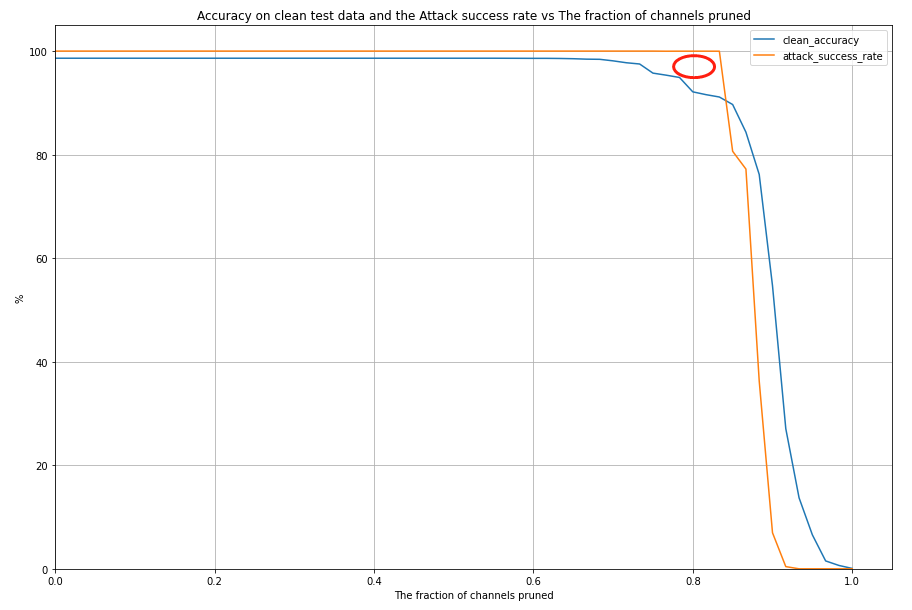